# RRFS Data

The Rapid Refresh Forecast System (RRFS) is undergoing rapid development. There are prototype products available on the cloud on AWS. Some files have an index file, others do not.

## **1 - Start here!**

This cell will install conda, which will allow us to install newer versions of some packages we need than pip alone on Google Colab. Run it by mousing over it and clicking the play button that appears on the left side. It will restart the notebook when it finishes, which will make a popup in the lower left corner saying the notebook crashed. It did not, we restarted it! You can close that and move on when it happens.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


## **2 - Install and import**

This cell will usually take a minute or two to run. It will install and import all the python packages we need.

In [1]:
# This installs and imports all the python packages/modules we need and will use later
!mamba install -q -c conda-forge cartopy contextily pyepsg pyproj pygrib netCDF4
import numpy as np
import os
from urllib.request import urlretrieve

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
from cartopy import cartopy, crs as ccrs, feature as cfeature

import xarray as xr
import pygrib
import netCDF4 as nc
import pandas as pd
import json
from pyproj.crs import CRS

from datetime import datetime, timedelta
import contextily as cx

import warnings
warnings.filterwarnings("ignore")

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


/usr/local/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
import requests

## **3 - Set options and go!**

Set all your options in the form below and go!

In [11]:
#################### FORM STUFF HERE ###################################################################################
#@title Plot Config { vertical-output: true, form-width: "50%", display-mode: "form" }
#@markdown Which Initialization Date?
init_date = "2023-04-03" #@param {type:"date"}
init_date = datetime.strptime(init_date,'%Y-%m-%d')
init_strftime = init_date.strftime('%Y%m%d')
print(init_strftime)
init_cyc = "18" #@param {type:"date"}
init_cyc = datetime.strptime(init_cyc,'%H')
init_strfcyc = init_cyc.strftime('%H')
print(init_strfcyc)
init_fhr = "18" #@param {type:"date"}
init_fhr = datetime.strptime(init_fhr,'%H')
init_strfhr = init_fhr.strftime('%H')
print(init_strfhr)





20230403
18
18


### Determine the file-subset of our variable

The GRIB2 file format stacks binary representations of 2D arrays under a top-level header. This means that instead of downloading and opening the whole file of 170+ variables (150MB+), we can read from a byte offset of just a single variable (or several). The NOAA HRRR data comes with a sidecar index file that specifies start-byte positions for each variable. These files have the same name as the HRRR file, suffixed with `.idx`. 

Let's use this to calculate the offset of the variable we want, before making the data request.

In [14]:
# AWS Direct URL
#url = f"https://noaa-rrfs-pds.s3.amazonaws.com/rrfs_a/rrfs_a.20230403/17/rrfs.t17z.natlev.f015.conus_3km.grib2"
#  https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220201/conus/hrrr.t12z.wrfsfcf36.grib2
#print(url)

url2 = f"https://noaa-rrfs-pds.s3.amazonaws.com/rrfs_a/rrfs_a." + init_strftime+ "/" + init_strfcyc + "/rrfs.t" + init_strfcyc + "z.natlev.f0" + init_strfhr + ".conus_3km.grib2"
print(url2)

https://noaa-rrfs-pds.s3.amazonaws.com/rrfs_a/rrfs_a.20230403/18/rrfs.t18z.natlev.f018.conus_3km.grib2


In [15]:
# Fetch the idx file by appending the .idx file extension to our already formatted URL
r = requests.get(f"{url2}.idx")
idx = r.text.splitlines()

# Take a peek at the content of the index
print(*idx[1200:1300], sep="\n")

1201:1035804090:d=2023040318:RWMR:64 hybrid level:18 hour fcst:
1202:1035804278:d=2023040318:SNMR:64 hybrid level:18 hour fcst:
1203:1035804466:d=2023040318:GRLE:64 hybrid level:18 hour fcst:
1204:1035804654:d=2023040318:PMTF:64 hybrid level:18 hour fcst:
1205:1036440405:d=2023040318:PMTC:64 hybrid level:18 hour fcst:
1206:1036556762:d=2023040318:TCDC:64 hybrid level:18 hour fcst:
1207:1036556950:d=2023040318:HGT:64 hybrid level:18 hour fcst:
1208:1037570809:d=2023040318:TMP:64 hybrid level:18 hour fcst:
1209:1038571609:d=2023040318:SPFH:64 hybrid level:18 hour fcst:
1210:1040244546:d=2023040318:UGRD:64 hybrid level:18 hour fcst:
1211:1041294325:d=2023040318:VGRD:64 hybrid level:18 hour fcst:
1212:1042177290:d=2023040318:VVEL:64 hybrid level:18 hour fcst:
1213:1044633714:d=2023040318:DZDT:64 hybrid level:18 hour fcst:
1214:1045292625:d=2023040318:TKE:64 hybrid level:18 hour fcst:
1215:1045292813:d=2023040318:MASSDEN:64 hybrid level:18 hour fcst:aerosol=Particulate Organic Matter Dry:ae

In [ ]:
#print(file,url2)

In [38]:
#################### FORM STUFF HERE ###################################################################################

#@markdown Which Day?
day = "1" #@param [1, 2, 3, 4, 5]
valid_date = init_date + timedelta(hours = 12, days = int(day))
valid_date_start = valid_date - timedelta(hours = 24)
valid_strftime = valid_date.strftime('%HZ %m-%d-%Y')
#@markdown ERO or Severe?
hazard = "Severe" #@param ["ERO", "Severe"]
#@markdown If Day 1 severe, which hazard?
severe_hazard = "TOR" #@param ["TOR", "HAIL", "WIND"]
#@markdown If ERO, which ERO version?
ero_version = "GEFS2022-UFVS" #@param ["GEFS2022", "GEFS2022-UFVS", "GEFS2020", "GEFS2019", "NSSL", "NSSL2", "NSSL3", "NSSL4", "NSSL5", "HRRR", "HRRR2", "BLEND"]
ero_version_dict = {"GEFS2022" : "PROBS_FV3GEFSR_V2022_GEFSO",
                "GEFS2022-UFVS" : "PROBS_FV3GEFSR_V2022_UFVS_GEFSO",
                "GEFS2020" : "PROBS_V2020FFAIR_P0_GEFSO",
                "GEFS2019" : "PROBS_V2019FFAIR_P0_GEFSO",
                "NSSL" : "HREF_NSSL_PROBS_V2021FFAIR",
                "NSSL2" : "HREF_NSSL2_PROBS_V2021FFAIR",
                "NSSL3" : "HREF_NSSL3_PROBS_V2021FFAIR",
                "NSSL4" : "HREF_NSSL4_PROBS_V2021FFAIR",
                "NSSL5" : "HREF_NSSL5_PROBS_V2021FFAIR",
                "HRRR" : "PROBS_V2021FFAIR_HRRR",
                "HRRR2" : "PROBS_V2022FFAIR_HRRR",
                "BLEND" : "PROBS_BLEND"}
#@markdown What map domain?
dom = "CONUS" #@param ["Custom", "CONUS", "ECONUS", "---- WESTERN REGION ----", "WR","NR","UT","AZ","SWUS","PNW", "---- CENTRAL REGION ----","CR", "NP", "GL", "CUS", "CO", "---- SOUTHERN REGION ----", "SR", "TXOK", "SE", "---- EASTERN REGION ----", "ER", "NE"]
#@markdown Pick a map theme
map_theme = "ESRI Light Grey" #@param ["Light Shaded Relief", "Stamen Toner Light", "Positron", "Dark Matter", "Dark Grey Matter", "ESRI Light Grey", "ESRI Dark Grey"]
if "Dark" in map_theme:
  font_color='w'
  face_color='#272727'
else:
  font_color = 'k'
  face_color = 'w'
#@markdown Set the map scale offset from default (i.e. a 1 would scale up one level [make labels bigger])
map_scale_offset = "1" #@param ["-2","-1", "0", "1","2"]
map_zoom_offset = int(map_scale_offset)

#@markdown Do you want to plot verification? (WPC Practically Perfect)
pp_verif = False #@param {type:"boolean"}
#@markdown Do you want LSRs? (it has to be in the past)
lsr_opt = False #@param {type:"boolean"}
heavy_rain_threshold =  1.0 #@param {type:"number"}
#@markdown Do you want Stage IV UFVS obs? (> 5yr ARI, Flash Food Guidance)
s4ariffg = False #@param {type:"boolean"}
#@markdown Enter custom lat/lon bounding box if custom was selected
custom_bottom_lat =  29.4284 #@param {type:"number"}
custom_left_lon = -105.811 #@param {type:"number"}
custom_top_lat =  40.7025#@param {type:"number"}
custom_right_lon = -88.8568 #@param {type:"number"}

#@markdown Enter a custom name if you want (mainly used for filename)
custom_name = "Jack" #@param {type:"string"}

day1_elements = ["NSSL1", "NSSL2", "NSSL3", "NSSL4", "NSSL5", "HRRR", "HRRR2", "BLEND"]

if hazard == "ERO" and int(day) > 1 and ero_version in day1_elements:
  print("Selected ERO product is only available on Day 1. Fixing this for you this time, but next time, try to be more careful!")
  day = "1"
else:
  pass

if hazard == "Severe" and int(day) > 3:
  print("Hey now, severe outlooks in this notebook are only available out to day 3 (if you know where the days 4+ gribs are, lemme know). Setting it back to day 3 for you.")
  day = "3"
else:
  pass
  
# set up some global variables here
#proj = ccrs.epsg(3857)
proj = ccrs.Mercator.GOOGLE
latloncrs = ccrs.PlateCarree()

# Setup a domain dictionary to make things a bit easier
# Zoom offset will be the integeter subtracted from the calculated zoom scale for map tiles
# Legend is the legend location: 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

domain_dict = {"Custom":{"west":custom_left_lon,
                        "south":custom_bottom_lat,
                        "east":custom_right_lon,
                        "north":custom_top_lat,
                        "zoom_adj": map_zoom_offset,
                        "legend":3},
               
               "CONUS":{"west":-125.650,
                    "south":23.377,
                    "east":--66.488,
                    "north":50.924,
                    "zoom_adj": 0,
                    "legend":4},
               
               "ECONUS":{"west":-104.36,
                    "south":24.735,
                    "east":-66.453,
                    "north":49.755,
                    "zoom_adj": 0,
                    "legend":4},

               "WR":{"west":-126.917,
                    "south":30.586,
                    "east":-102.740,
                    "north":49.755,
                    "zoom_adj": 1,
                     "legend":4},

               "UT":{"west":-117.02,
                      "east":-106.92,
                      "north":42.13,
                      "south":36.80,
                      "zoom_adj": 1,
                     "legend":4},
               
               "NR":{"west":-117.5177,
                    "south":41.9071,
                    "east":-103.38071,
                    "north":49.3085,
                    "zoom_adj": 1,
                    "legend":4},
               
               "PNW":{"west":-125.4510,
                    "south":41.8754,
                    "east":-110.9318,
                    "north":49.5767,
                    "zoom_adj": 0,
                    "legend":4},
               
               "SWUS":{"west":-125.582,
                    "south":31.136,
                    "east":-108.689,
                    "north":42.859,
                    "zoom_adj": 0,
                    "legend":3},
               
               "AZ":{"west":-115.596,
                    "south":31.113,
                    "east":-107.887,
                    "north":37.446,
                    "zoom_adj": 0,
                    "legend":4},
              
               "CR":{"west":-111.534,
                    "south":35.118,
                    "east":-82.263,
                    "north":49.755,
                    "zoom_adj": 1,
                    "legend":1},
               
               "NP":{"west":-105.244,
                    "south":42.173,
                    "east":-89.426,
                    "north":49.474,
                    "zoom_adj": 1,
                    "legend":4},
               
               "GL":{"west":-97.606,
                    "south":38.735,
                    "east":-74.916,
                    "north":49.292,
                    "zoom_adj": 1,
                    "legend":3},
               
               "CUS":{"west":-111.553,
                    "south":34.794,
                    "east":-88.533,
                    "north":46.357,
                    "zoom_adj": 1,
                    "legend":3},
               
               "CO":{"west":-109.2934,
                    "south":36.8186,
                    "east":-101.8524,
                    "north":47.35,
                    "zoom_adj": 1,
                    "legend":4},
               
               "SR":{"west":-109.758,
                    "south":23.313,
                    "east":-78.247,
                    "north":37.899,
                    "zoom_adj": 1,
                    "legend":3},
               
               "TXOK":{"west":-106.95,
                    "south":26.06,
                    "east":-86.76,
                    "north":37.76,
                    "zoom_adj": 0,
                    "legend":4},
               
               "SE":{"west":-92.974,
                    "south":24.578,
                    "east":-75.1311,
                    "north":37.390,
                    "zoom_adj": 0,
                    "legend":4},
               
               "ER":{"west":-85.629,
                    "south":31.723,
                    "east":-66.465,
                    "north":47.676,
                    "zoom_adj": 0,
                    "legend":4},
               
               "NE":{"west":-85.629,
                    "south":37.654,
                    "east":-66.00,
                    "north":47.825,
                    "zoom_adj": 1,
                    "legend":4},
               
               "CONUS":{"west":-125.650,
                    "south":23.377,
                    "east":-66.488,
                    "north":50.924,
                    "zoom_adj": 0,
                    "legend":4},
               
               "ECONUS":{"west":-104.36,
                    "south":24.735,
                    "east":-66.453,
                    "north":49.755,
                    "zoom_adj": 0,
                    "legend":4},

}

west = domain_dict[dom]["west"]
south = domain_dict[dom]["south"]
east = domain_dict[dom]["east"]
north = domain_dict[dom]["north"]
map_zoom_offset = domain_dict[dom]["zoom_adj"]
LLOC = domain_dict[dom]["legend"]


# Set up the URL
#url_base = "http://schumacher.atmos.colostate.edu/gherman/ffair/"
#if hazard == "ERO":
#  file = f'EXQPF_DAY{day}_{ero_version_dict[ero_version]}_{init_strftime}.grib2'
#elif hazard == "Severe":
#  if int(day) > 1:
#    file = f'SEVERE_DAY{day}_PROBS_V1P1_GEFSO_{init_strftime}.grib2'
#  elif day == "1":
#    file = f'{severe_hazard}_DAY{day}_PROBS_V1P1_GEFSO_{init_strftime}_STD.grib2'
#url = url_base+file
#init_strftime

#file = f'{init_strftime}_rrfs.t17z.natlev.f015.conus_3km.grib2'
file = f'{init_strftime}_rrfs_a.t' + init_strfcyc + 'z.natlev.f0' + init_strfhr + '.conus_3km.grib2'


################## DOWNLOAD HERE #######################################################################################
print('Looking for grib file...')
if os.path.exists(file):
  print("   > Grib already exists")
else:
  try:
    print("   > Downloading grib")
    urlretrieve(url2, file)
  except:
    print("     >> Unable to get file")
    
print('   > Processing grib file')
gribdata = pygrib.open(file)
csu_mlp = gribdata.message(1236)
lats, lons = csu_mlp.latlons()
gribdata.close()
print(f'     >> Max: {int(np.max(csu_mlp.values)*1)}%')
print(f'     >> Min: {int(np.min(csu_mlp.values)*1)}%')
#print("     Got it! Proceed.")


Looking for grib file...
   > Grib already exists
   > Processing grib file
     >> Max: 67%
     >> Min: -20%


In [26]:
# You can see it has a 1-indexed base line number, staring byte position, date, variable, atmosphere level,
# and forecast description. The lines are colon-delimited. 

# Let's grab surface temperature `TMP:surface`.
sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
sfc_temp_idx = [l for l in idx if "REFC:entire atmosphere" in l][0].split(":")

print("REFC line:", sfc_temp_idx)

# Pluck the byte offset from this line, plus the beginning offset of the next line
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None

# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None

print(f"Byte range: {range_start}-{range_end}")

REFC line: ['1236', '1058128149', 'd=2023040318', 'REFC', 'entire atmosphere (considered as a single layer)', '18 hour fcst', '']
Byte range: 1058128149-1059527604


In [34]:
import tempfile
file2 = tempfile.NamedTemporaryFile(prefix="refd_", delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url2, headers=headers, stream=True)

with file2 as f:
    f.write(resp.content)

#print(f)  
print("   > Downloading grib")

file2= f'{init_strftime}_rrfs_a.t' + init_strfcyc + 'z.natlev.f0' + init_strfhr + '.conus_3km_small.grib2'

urlretrieve(url2, file2)

   > Downloading grib


('20230403_rrfs_a.t18z.natlev.f018.conus_3km_small.grib2',
 <http.client.HTTPMessage at 0x7efc4ec8f100>)

Making Severe Plot...
   > Initializing map
   > Adding fancy map tiles
   > Contouring ML SVR
   > Adding legend
   > Plot saved as CONUS_CSU_SVR_TOR_Day1_20230403.png


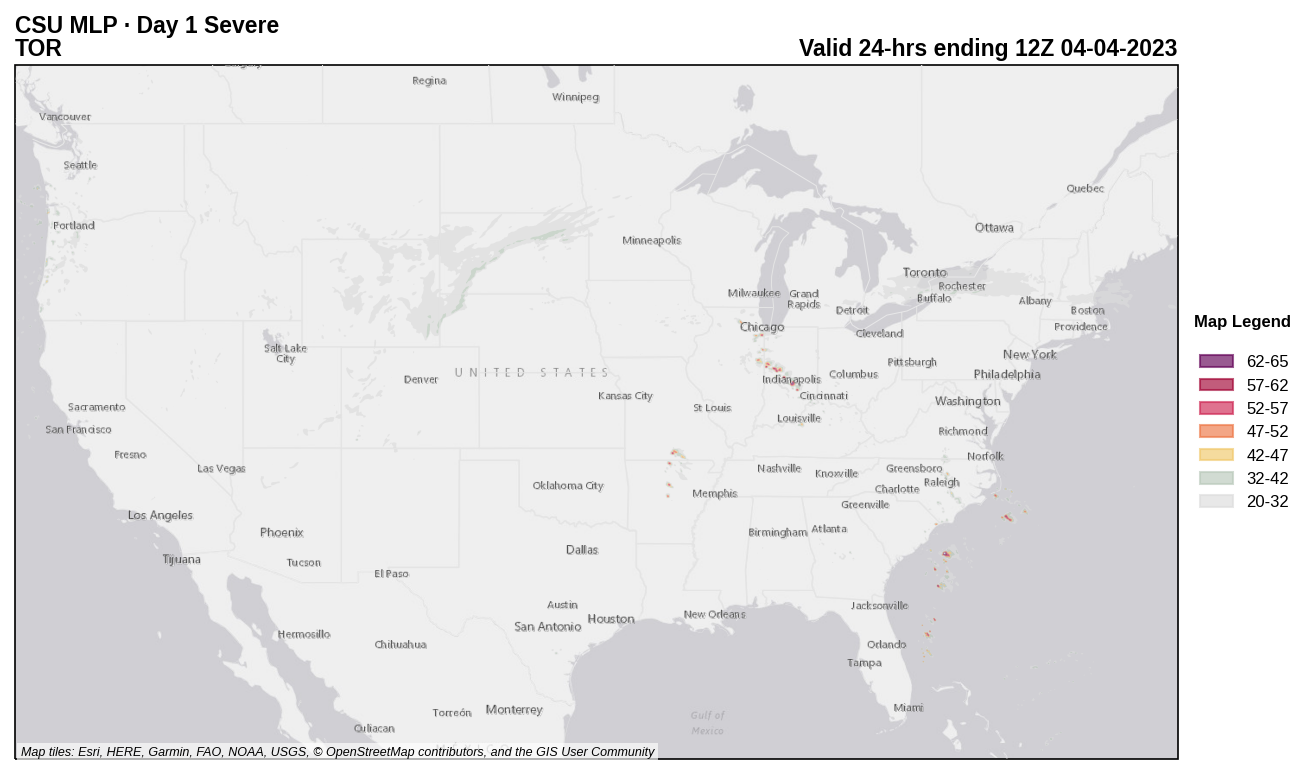

In [39]:
################## PLOT HERE ###########################################################################################

def blankmap():
    global maplayertext1, maplayertext2, ax
    print('   > Initializing map')
    plt.figure(figsize=(10,8),frameon=True, facecolor=face_color)
    F = plt.gcf()  # Gets the current figure
    ax = plt.axes(projection=proj)
    
    zoom = (cx.tile._calculate_zoom(west, 
                                    south, 
                                    east, 
                                    north) - map_zoom_offset)

    ax.set_extent([west, 
                  east, 
                  south, 
                  north], crs=latloncrs)
    

    print('   > Adding fancy map tiles')
    maplayertext2 = ""
    maylayertext1 = ""
    if map_theme == "Light Shaded Relief":
      ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#FAFAF8', zorder=-2)
      cx.add_basemap(ax, source="https://basemap.nationalmap.gov/arcgis/rest/services/USGSShadedReliefOnly/MapServer/tile/{z}/{y}/{x}", 
                      attribution=False, alpha =0.8, zorder=-1)
      maplayertext1 = "Map tiles: © USGS Earth Resources Observation & Science (EROS) Center: GMTED2010" #for USGS Hillshade
      ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over the ocean
      ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over lakes
      cx.add_basemap(ax, source="http://services.arcgisonline.com/arcgis/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}", 
                      attribution=False, zoom=zoom, zorder=50)
      cx.add_basemap(ax, source='http://services.arcgisonline.com/arcgis/rest/services/Reference/World_Transportation/MapServer/tile/{z}/{y}/{x}',
                      zorder=49)
      maplayertext2 = "Esri, HERE, Garmin, OpenStreetMap contributors"

    elif map_theme == "Stamen Toner Light":
      cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, zoom=zoom, zorder=-1, attribution=False)
      cx.add_basemap(ax, source=cx.providers.Stamen.TonerHybrid, zoom=zoom, zorder=49, attribution=False)
      maplayertext1 = str(cx.providers.Stamen.TonerLite.attribution)

    elif map_theme == "Positron":
      cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, zorder=-1, attribution=False)
      ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#e5e2e3', facecolor='none', linewidth=0.5, zorder=48, alpha=0.5)) # adds state borders
      ax.add_feature(cfeature.COASTLINE, edgecolor="#FAFAF8", facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
      ax.add_feature(cfeature.BORDERS, edgecolor="#FAFAF8", facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
      cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, zoom=zoom, zorder=49, attribution=False)
      maplayertext1 = "Map tiles: " + str(cx.providers.CartoDB.Positron.attribution)

    elif map_theme == "Dark Grey Matter":
      ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-2)
      ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#232227', zorder=1) # adds fill over the ocean
      ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#232227', zorder=1) # adds fill over lakes
      #cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterNoLabels, zorder=-1, attribution=False)
      ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#1c1c1c', facecolor='none', linewidth=0.5, zorder=48, alpha=0.5)) # adds state borders
      ax.add_feature(cfeature.COASTLINE, edgecolor='k', facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
      ax.add_feature(cfeature.BORDERS, edgecolor='k', facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
      cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterOnlyLabels, zoom=zoom, zorder=49, attribution=False)
      maplayertext1 = "Map tiles: " + str(cx.providers.CartoDB.DarkMatter.attribution)

    elif map_theme == "Dark Matter":
      cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterNoLabels, zorder=-1, attribution=False)
      ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#1c1c1c', facecolor='none', linewidth=0.5, zorder=48, alpha=0.5)) # adds state borders
      ax.add_feature(cfeature.COASTLINE, edgecolor='k', facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
      ax.add_feature(cfeature.BORDERS, edgecolor='k', facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
      cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterOnlyLabels, zoom=zoom, zorder=49, attribution=False)
      maplayertext1 = "Map tiles: " + str(cx.providers.CartoDB.DarkMatter.attribution)

    elif map_theme == "ESRI Light Grey":
      cx.add_basemap(ax, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', zorder=-1, attribution=False)
      ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#e4e4e4', facecolor='none', linewidth=0.5, zorder=48)) # adds state borders
      ax.add_feature(cfeature.COASTLINE, edgecolor='#efefef', facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
      ax.add_feature(cfeature.BORDERS, edgecolor='#efefef', facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
      cx.add_basemap(ax, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Reference/MapServer/tile/{z}/{y}/{x}', zoom=zoom, zorder=49, attribution=False)
      maplayertext1 = "Map tiles: Esri, HERE, Garmin, FAO, NOAA, USGS, © OpenStreetMap contributors, and the GIS User Community"

    elif map_theme == "ESRI Dark Grey":
      cx.add_basemap(ax, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', zorder=-1, attribution=False)
      ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#363638', facecolor='none', linewidth=0.5, zorder=48, alpha=0.5)) # adds state borders
      ax.add_feature(cfeature.COASTLINE, edgecolor='#3f3f3f', facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
      ax.add_feature(cfeature.BORDERS, edgecolor='#3f3f3f', facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
      cx.add_basemap(ax, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Reference/MapServer/tile/{z}/{y}/{x}', zoom=zoom, zorder=49, attribution=False)
      maplayertext1 = "Map tiles: Esri, HERE, Garmin, © OpenStreetMap contributors, and the GIS User Community"

def drawmap(DATA,TITLESTRING,PROD,UNITS,LEVS,LABS):
    F = plt.gcf()  # Gets the current figure
    ax = plt.gca()  # Gets the current axes
    print('   > Adding legend')
    proxy = [mpatches.Patch(color = pc.get_facecolor()[0]) for pc in DATA.collections]
    LLABS = LABS
    #LLABS = []
    #for i in range(0, len(LEVS)-1):
    #  label = str(LEVS[i])+"-"+str(LEVS[i+1])+UNITS
    #  LLABS.append(label)
    if hazard == "ERO":
      if pp_verif:
        LLABS.append("Verif 5%")
        proxy.append(Line2D([0], [0], color="#b9c9ba", lw=2))
        LLABS.append("Verif 15%")
        proxy.append(Line2D([0], [0], color="#f1c86a", lw=2))
        LLABS.append("Verif 27%")
        proxy.append(Line2D([0], [0], color="#ed7645", lw=2))
        LLABS.append("Verif 40%")
        proxy.append(Line2D([0], [0], color="#ce2754", lw=2))
        LLABS.append("Verif 70%")
        proxy.append(Line2D([0], [0], color="#9f00a6", lw=2))
      if lsr_opt:
        LLABS.append("Heavy Rain LSR")
        proxy.append(plt.scatter([], [], marker=get_marker("\uf740"), color="#023945", edgecolor='none', s=50))
        LLABS.append("Flood LSR")
        proxy.append(plt.scatter([], [], marker=get_marker("\uf773"), color="tab:red", edgecolor='none', s=50))
      
      if s4ariffg:
        LLABS.append("StageIV > 5yr ARI")
        proxy.append(plt.scatter([], [], marker="_", color="grey", edgecolor='none', s=50, linewidths=1))
        LLABS.append("StageIV > FFG")
        proxy.append(plt.scatter([], [], marker="|", color="grey", edgecolor='none', s=50, linewidths=1))
    elif hazard == "Severe":
      if lsr_opt:
        if int(day) > 1:
          LLABS.append("Wind LSR")
          proxy.append(plt.scatter([], [], marker=get_marker("\uf72e"), color="blue", edgecolor='none', s=50))
          LLABS.append("Hail LSR")
          proxy.append(plt.scatter([], [], marker=get_marker("\uf73b"), color="green", edgecolor='none', s=50))
          LLABS.append("TOR LSR")
          proxy.append(plt.scatter([], [], marker=get_marker("\uf76f"), color="tab:red", edgecolor='none', s=50))
        elif day == "1":
          if severe_hazard == "HAIL":
            LLABS.append("Hail LSR")
            proxy.append(plt.scatter([], [], marker=get_marker("\uf73b"), color="green", edgecolor='none', s=50))
          if severe_hazard == "WIND":
            LLABS.append("Wind LSR")
            proxy.append(plt.scatter([], [], marker=get_marker("\uf72e"), color="blue", edgecolor='none', s=50))
          if severe_hazard == "TOR":
            LLABS.append("Tor LSR")
            proxy.append(plt.scatter([], [], marker=get_marker("\uf76f"), color="tab:red", edgecolor='none', s=50))

    proxy = proxy[::-1]
    LLABS = LLABS[::-1]

    l = plt.legend(handles=proxy, labels=LLABS, fontsize='8',frameon=False,
                   bbox_to_anchor=(1.001, 0.5), loc=6)
    l.set_zorder(100)
    for text in l.get_texts():
      text.set_color(font_color)
    lframe = l.get_frame()
    lframe.set_color(face_color)
    #l.set_title(f'CSU MLP Day {str(day)} \n {element} ERO \n  Valid {valid_strftime}')
    #plt.setp(l.get_title(), multialignment='center', fontsize=8, weight='bold')
    l.set_title(f'Map Legend \n')
    plt.setp(l.get_title(), multialignment='center', fontsize=8, weight='bold')
    
    title_text1 = f'CSU MLP · Day {str(day)} {hazard}'
    if hazard == "ERO":
      title_text2 = f'Version: {ero_version}'
    elif hazard =="Severe":
      if day == "1":
        title_text2 = f'{severe_hazard}'
      elif int(day) > 1:
        title_text2 = f'Aggregate Severe'
    title_validtext = f'Valid 24-hrs ending {valid_strftime}'

    plt.text(0.0, 1.04, title_text1, transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom',
            fontsize=11, color=font_color, weight='bold')
    plt.text(0.0, 1.04, title_text2, transform=ax.transAxes, horizontalalignment='left', verticalalignment='top',
            fontsize=11, color=font_color, weight='semibold')
    plt.text(1.0, 1.04, title_validtext, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top',
            fontsize=11, color=font_color, weight='bold')
            
    if maplayertext1 != "":
      if maplayertext2 !="":
          plt.text(0.005, 0.005, 'Map layers: %s // %s' % (maplayertext1,maplayertext2), 
                transform = ax.transAxes,horizontalalignment='left',fontsize=6,color=font_color, style='italic', zorder=99,
                bbox=dict(facecolor=face_color,edgecolor='none', pad=1.8, alpha=0.65))
      else:
        plt.text(0.005, 0.005, '%s' % (maplayertext1), 
                  transform = ax.transAxes,horizontalalignment='left',fontsize=6,color=font_color, style='italic', zorder=99,
                bbox=dict(facecolor=face_color,edgecolor='none', pad=1.8, alpha=0.65))
   
    if dom == "Custom" and custom_name:
      custom_name_sanitized = custom_name.replace(" ","")
      file_id = '%s_%s_%s' % (custom_name_sanitized, PROD, init_strftime)
    else:
      file_id = '%s_%s_%s' % (dom, PROD, init_strftime)
    filename = '%s.png' % (file_id)
    plt.savefig(filename, bbox_inches='tight', facecolor=face_color) # Saves the figure with small margins
    print(f'   > Plot saved as {filename}')
    plt.show()

def plot_ML_SVR():
    print("Making Severe Plot...")
    svr = csu_mlp.values
    blankmap()
    print('   > Contouring ML SVR')

    SVR_COLS = ["#dcdcdc", "#b9c9ba", "#f1c86a", "#ed7645", "#ce2754", "#a20435","#630157"]
    SVR_LEVS = [0.02, 0.05, 0.10, 0.15, 0.30, 0.45, 0.60, 1.00]
    SVR_LEVS = [0.52, 0.55, 0.58, 0.60, 0.61, 0.62, 0.65]
    SVR_LEVS = [20, 32, 42, 47, 52, 57, 62, 65]
    SVR_Text = ["2-5%", "5-10%", "10-15%", "15-30%", "30-45%", "45-60%", "60-100%"]
    SVR_Text = ["52-55%", "55-58%", "58-60%", "60-61%", "61-62%", "62-65%"]
    SVR_Text = ["20-32", "32-42", "42-47", "47-52", "52-57", "57-62", "62-65"]
    SWO = plt.contourf(lons,lats,svr,SVR_LEVS,colors=SVR_COLS,extend='neither',alpha=0.65, transform=latloncrs,antialiased = True)

    if lsr_opt:
      day_delta = int(day) - 1
      lsr_start = init_date + timedelta (days = day_delta, hours = 12)
      lsr_start = lsr_start.strftime('%Y-%m-%dT%H:%M')
      lsr_end = valid_date.strftime('%Y-%m-%dT%H:%M')
      lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"Z&ets="+lsr_end+"Z&fmt=csv"
      csv_name = "lsr_"+lsr_start+"_"+lsr_end+".csv"

      try:
        file_exists = os.path.exists(csv_name)
        if file_exists:
          print("   > LSRs file already exists")
        else:
          print("   > Grabbing LSRs")
          urlretrieve(lsr_url, csv_name)

        LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
        LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
        LSRs['LAT'] = LSRs.LAT.astype(float)
        LSRs['LON'] = LSRs.LON.astype(float)
        LSRs_hail = LSRs[(LSRs.TYPECODE == 'H') & (LSRs.MAG >= 1)]
        hail_lats= LSRs_hail['LAT'].to_numpy()
        hail_lons= LSRs_hail['LON'].to_numpy()
        LSRs_wind = LSRs[((LSRs.TYPECODE == 'G') & (LSRs.MAG >= 58)) | (LSRs.TYPECODE == 'D')]
        wind_lats= LSRs_wind['LAT'].to_numpy()
        wind_lons= LSRs_wind['LON'].to_numpy()
        LSRs_tor = LSRs[(LSRs.TYPECODE == 'T')]
        tor_lats= LSRs_tor['LAT'].to_numpy()
        tor_lons= LSRs_tor['LON'].to_numpy()
        print("     >> Plotting LSRs")
        if int(day) > 1:
          plt.scatter(hail_lons, hail_lats, marker=get_marker("\uf73b"), color="green", edgecolor='none', s=55,transform=latloncrs)
          plt.scatter(wind_lons, wind_lats, marker=get_marker("\uf72e"), color="blue", edgecolor='none', s=55,transform=latloncrs)
          plt.scatter(tor_lons, tor_lats, marker=get_marker("\uf76f"), color="tab:red", edgecolor='none', s=55,transform=latloncrs)
        elif severe_hazard == "WIND":
           plt.scatter(wind_lons, wind_lats, marker=get_marker("\uf72e"), color="blue", edgecolor='none', s=55,transform=latloncrs)
        elif severe_hazard == "HAIL":
          plt.scatter(hail_lons, hail_lats, marker=get_marker("\uf73b"), color="green", edgecolor='none', s=55,transform=latloncrs)
        elif severe_hazard == "TOR":
          plt.scatter(tor_lons, tor_lats, marker=get_marker("\uf76f"), color="tab:red", edgecolor='none', s=55,transform=latloncrs)

      except:
        print("     !> No LSRs for you")

    units = '%'
    title = ""
    if int(day) > 1:
      prodid = 'CSU_SVR_Day'+str(day)
    else:
      prodid = 'CSU_SVR_'+severe_hazard+'_Day'+str(day)

    drawmap(SWO, title, prodid, units, SVR_LEVS, SVR_Text)

matplotlib.rcParams['figure.dpi'] = 150 # make high quality figure
if hazard == "ERO":
  plot_ML_ERO()
elif hazard == "Severe":
  plot_ML_SVR()


Herbie-stuff follows.....trying to skip...














STOP HERE!!!!


























In [ ]:
!!  Code from  https://herbie.readthedocs.io/en/latest/user_guide/_model_notebooks/rrfs.html

In [ ]:
!pip install git+https://github.com/blaylockbk/Herbie.git

In [ ]:
!pip install eccodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from herbie import FastHerbie

RuntimeError: ignored

In [ ]:
from herbie import Herbie
from toolbox import EasyMap, pc
from paint.standard2 import cm_tmp

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

RuntimeError: ignored

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
H = Herbie("2021-07-23", model="rrfs", fxx=1, member=1)

✅ Found ┊ model=rrfs ┊ product=mean ┊ 2021-Jul-23 00:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws


In [ ]:
H.SOURCES

{'aws': 'https://noaa-rrfs-pds.s3.amazonaws.com/rrfs.20210723/00/ensprod/rrfsce.t00z.conus.mean.f01.grib2',
 'aws-mem': 'https://noaa-rrfs-pds.s3.amazonaws.com/rrfs.20210723/00/mem01/rrfs.t00z.mem01.meanf001.grib2'}

In [ ]:
H.PRODUCTS

{'mean': 'ensemble mean',
 'avrg': 'ensemble products: ???',
 'eas': 'ensemble products: ???',
 'ffri': 'ensemble products: ???',
 'lpmm': 'ensemble products: ???',
 'pmmn': 'ensemble products: ???',
 'prob': 'ensemble products: ???',
 'testbed.conus': 'surface grids (one for each member)',
 'na': 'native grids (one for each member)'}

In [ ]:
ds = H.xarray("TMP:2 m")

👨🏻‍🏭 Created directory: [C:\Users\blaylock\data\rrfs\20210723\mem01]


C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")


In [ ]:
ds

<xarray.Dataset>
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2021-07-23
    step                 timedelta64[ns] 01:00:00
    heightAboveGround    float64 2.0
    latitude             (y, x) float64 21.14 21.14 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2021-07-23T01:00:00
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 295.3 295.3 295.3 ... 287.7 287.8 287.8
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   rrfs
    product:                 mean
    description:             Rapid Refresh Forecast System (RRFS) Ensemble
    remote_grib:             https://noaa-rrfs-pds.s3.amazonaws.com/rrfs.2021...
    local_grib:              C:\Users\blaylock\data\rrfs\20210723\mem01\subse...
    searchString:            TMP:2 m

Text(0.0, 1.0, 'RRFS: ensemble mean')

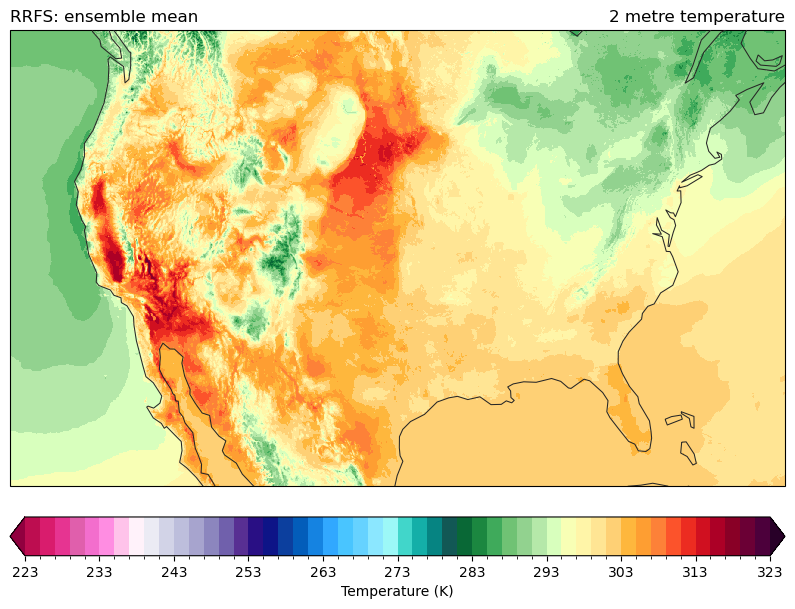

In [ ]:
ax = EasyMap(crs=ds.herbie.crs, figsize=[10, 8]).ax
p = ax.pcolormesh(
    ds.longitude, ds.latitude, ds.t2m, transform=pc, **cm_tmp(units="K").cmap_kwargs
)
plt.colorbar(
    p, ax=ax, orientation="horizontal", pad=0.05, **cm_tmp(units="K").cbar_kwargs
)

ax.set_title(ds.t2m.GRIB_name, loc="right")
ax.set_title(f"{H.model.upper()}: {H.product_description}", loc="left")

In [ ]:
# AWS Direct URL
url = f"https://noaa-rrfs-pds.s3.amazonaws.com/rrfs.20230331/00/mem01/rrfs.t00z.mem01.meanf001.grib2"
# https://noaa-rrfs-pds.s3.amazonaws.com/rrfs.20210723/00/mem01/rrfs.t00z.mem01.meanf001.grib2
#  https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220201/conus/hrrr.t12z.wrfsfcf36.grib2
print(url)

https://noaa-rrfs-pds.s3.amazonaws.com/rrfs.20230331/00/mem01/rrfs.t00z.mem01.meanf001.grib2


In [ ]:
import requests

In [ ]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)

#headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url)

with file as f:
    f.write(resp.content)

## Missing index files
We have to download the full file.

In [ ]:
H = Herbie(
    "2021-07-23", model="rrfs", product="testbed.conus", member=1, priority="aws-mem"
)

✅ Found ┊ model=rrfs ┊ product=testbed.conus ┊ 2021-Jul-23 00:00 UTC F00 ┊ GRIB2 @ aws-mem ┊ IDX @ aws-mem


In [ ]:
# no index file available. Have to download the full file.
H.download()

✅ Success! Downloaded RRFS from aws-mem             
	src: https://noaa-rrfs-pds.s3.amazonaws.com/rrfs.20210723/00/mem01/rrfs.t00z.mem01.testbed.conusf000.grib2
	dst: /p/cwfs/blaylock/data/rrfs/20210723/mem01/rrfsce.t00z.conus.testbed.conus.f00.grib2


In [ ]:
import xarray

In [ ]:
# Since we have the full file, we need to filter by keys to open the
# variable we want with cfgrib
x = xarray.open_dataset(
    H.get_localFilePath(),
    engine="cfgrib",
    backend_kwargs={
        "filter_by_keys": {"shortName": "2t", "typeOfLevel": "heightAboveGround"}
    },
)

In [ ]:
# Since we have the full file, we need to filter by keys to open the
# variable we want with cfgrib
x = xarray.open_dataset(
    f,
    engine="cfgrib",
    backend_kwargs={
        "filter_by_keys": {"shortName": "2t", "typeOfLevel": "heightAboveGround"}
    },
)

/usr/local/lib/python3.9/dist-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/usr/local/lib/python3.9/dist-packages/xarray/backends/cfgrib_.py:54: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


RuntimeError: ignored

Text(0.0, 1.0, 'RRFS: member 1')

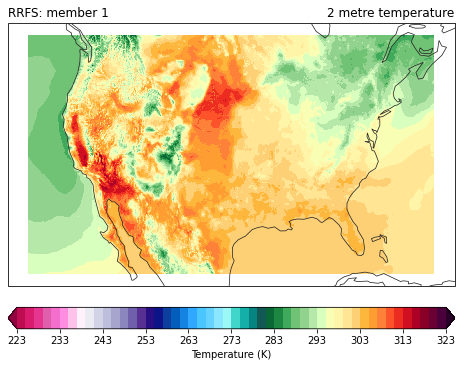

In [ ]:
ax = EasyMap(crs=x.herbie.crs, figsize=[8, 8]).ax
p = ax.pcolormesh(
    x.longitude, x.latitude, x.t2m, transform=pc, **cm_tmp(units="K").cmap_kwargs
)
plt.colorbar(
    p, ax=ax, orientation="horizontal", pad=0.05, **cm_tmp(units="K").cbar_kwargs
)

ax.set_title(x.t2m.GRIB_name, loc="right")
ax.set_title(f"{H.model.upper()}: member {H.member}", loc="left")

# Grid Mapping
Herbie attempts to parse the CF grid mapping from the GRIB data if it is available. This can be parsed by metpy.

In [ ]:
import metpy

In [ ]:
crs_info = x.metpy.parse_cf().metpy_crs.item()
crs_info.to_cartopy()

In [ ]:
crs_info.to_pyproj()

<Projected CRS: {"$schema": "https://proj.org/schemas/v0.2/projjso ...>
Name: undefined
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich